# 3-3,高阶API示范

Pytorch没有官方的高阶API，一般需要用户自己实现训练循环、验证循环、和预测循环。

作者通过仿照keras的功能对Pytorch的nn.Module进行了封装，设计了torchkeras.KerasModel类，

实现了 fit, evaluate，predict等方法，相当于用户自定义高阶API。

并示范了用它实现线性回归模型。

此外，作者还通过借用pytorch_lightning的功能，封装了类Keras接口的另外一种实现，即torchkeras.LightModel类。

并示范了用它实现DNN二分类模型。


torchkeras.KerasModel类和torchkeras.LightModel类看起来非常强大，但实际上它们的源码非常简单，不足200行。
我们在第一章中`一、Pytorch的建模流程`用到的训练代码其实就是torchkeras库的核心源码。

在实际应用中，由于有些模型的输入输出以及Loss结构和torchkeras的假设结构有所不同，直接调用torchkeras可能不能满足需求，不要害怕，copy出来
torchkeras.KerasModel或者torchkeras.LightModel的源码，在输入输出和Loss上简单改动一下就可以。


In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 
from python_cgtools.utils_date import *
from python_cgtools.utils_torch import *

torch.__version__ =  2.0.1+cu118
tensorboard.__version__ =  2.13.0
torchvision.__version__ =  0.15.2+cu118
pytorch_lightning.__version__ =  2.0.2
torchtext.__version__ =  0.15.2
torchdata.__version__ =  0.6.1
torchmetrics.__version__ =  0.11.4
torchkeras.__version__ =  3.8.2
yaml.__version__ =  6.0
tensorflow sed random seed fail.


In [2]:
start_time = time.time()
print_with_time("start.........")

2023-05-29 17:18:23:start.........


```
torch.__version__=1.10.0
torchkeras.__version__=3.2.2
```

### 一，线性回归模型

此范例我们通过继承torchkeras.Model模型接口，实现线性回归模型。

**1，准备数据**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
X = X.to(device)
w0 = torch.tensor([[2.0],[-3.0]])
w0 = w0.to(device)
b0 = torch.tensor([[10.0]])
b0 = b0.to(device)
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1]).to(device)  # @表示矩阵乘法,增加正态扰动


In [4]:
Y.device

device(type='cuda', index=0)

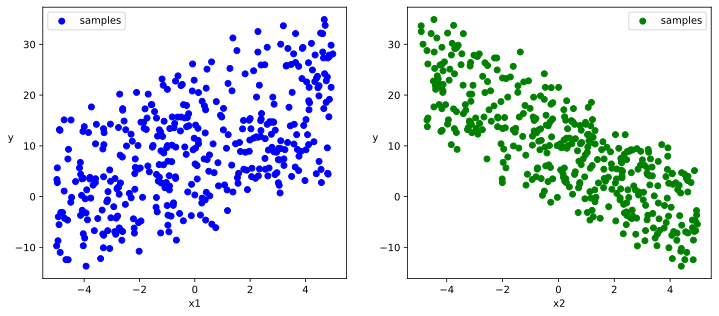

In [5]:
# 数据可视化
# can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].cpu(),Y[:,0].cpu(), c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1].cpu(),Y[:,0].cpu(), c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


![](./data/3-3-回归数据可视化.png)

In [6]:
#构建输入数据管道
ds = TensorDataset(X,Y)
ds_train,ds_val = torch.utils.data.random_split(ds,[int(400*0.7),400-int(400*0.7)])
dl_train = DataLoader(ds_train,batch_size = 10,shuffle=True,num_workers=0, collate_fn=cuda_collate_fn)
dl_val = DataLoader(ds_val,batch_size = 10,num_workers=0, collate_fn=cuda_collate_fn)

features,labels = next(iter(dl_train))


**2，定义模型**

In [7]:
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.fc = nn.Linear(2,1)
    
    def forward(self,x):
        return self.fc(x)

net = LinearRegression()
net = net.to(device)

In [8]:
summary(net,input_data=features)

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000088
--------------------------------------------------------------------------


'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nLinear-1                                     [-1, 1]                    3\n==========================================================================\nTotal params: 3\nTrainable params: 3\nNon-trainable params: 0\n--------------------------------------------------------------------------\nInput size (MB): 0.000069\nForward/backward pass size (MB): 0.000008\nParams size (MB): 0.000011\nEstimated Total Size (MB): 0.000088\n--------------------------------------------------------------------------'

```
--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
==========================================================================
Linear-1                                     [-1, 1]                    3
==========================================================================
Total params: 3
Trainable params: 3
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000008
Params size (MB): 0.000011
Estimated Total Size (MB): 0.000088
--------------------------------------------------------------------------
```

**3，训练模型**

In [9]:
import torchmetrics

net = LinearRegression()
model = KerasModel(net=net,
                   loss_fn = nn.MSELoss(),
                   metrics_dict = {"mae":torchmetrics.MeanAbsoluteError()},
                   optimizer= torch.optim.Adam(net.parameters(),lr = 0.05))
dfhistory = model.fit(train_data=dl_train,
      val_data=dl_val,
      epochs=20,
      ckpt_path='checkpoint.pt',
      patience=5,
      monitor='val_loss',
      mode='min')


<<<<<< ⚡️ cuda is used >>>>>>

================================================================================2023-05-29 17:18:25
Epoch 1 / 20

100%|██████████████████████████████████| 12/12 [00:00<00:00, 481.27it/s, val_loss=112, val_mae=8.75]
<<<<<< reach best val_loss : 112.02276134490967 >>>>>>

================================================================================2023-05-29 17:18:25
Epoch 2 / 20

100%|█████████████████████████████████| 12/12 [00:00<00:00, 481.26it/s, val_loss=64.9, val_mae=7.25]
<<<<<< reach best val_loss : 64.9212516148885 >>>>>>

================================================================================2023-05-29 17:18:25
Epoch 3 / 20

100%|█████████████████████████████████| 12/12 [00:00<00:00, 429.72it/s, val_loss=43.6, val_mae=6.15]
<<<<<< reach best val_loss : 43.62967824935913 >>>>>>

================================================================================2023-05-29 17:18:26
Epoch 4 / 20

100%|█████████████████████████████████| 12/12

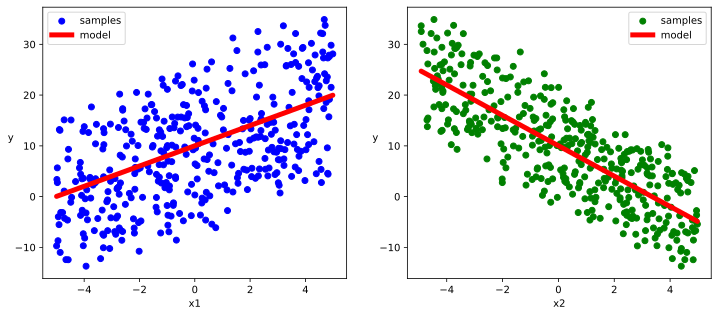

In [10]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = net.state_dict()["fc.weight"],net.state_dict()["fc.bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0].cpu(),Y[:,0].cpu(), c = "b",label = "samples")
ax1.plot(X[:,0].cpu(),(w[0,0]*X[:,0]+b[0]).cpu(),"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1].cpu(),Y[:,0].cpu(), c = "g",label = "samples")
ax2.plot(X[:,1].cpu(),(w[0,1]*X[:,1]+b[0]).cpu(),"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()


**4，评估模型**

In [11]:
dfhistory.tail()

,epoch,train_loss,train_mae,lr,val_loss,val_mae
15,16,4.042002,1.597926,0.05,4.260132,1.664127
16,17,4.010377,1.597588,0.05,4.265340,1.663035
17,18,3.973476,1.594527,0.05,4.251116,1.661019
18,19,3.992812,1.602766,0.05,4.258611,1.661009
19,20,3.998372,1.596528,0.05,4.273712,1.662538


```
	train_loss	train_mae	val_loss	val_mae	epoch
15	4.339620	1.635648	3.119237	1.384351	16
16	4.313104	1.631849	2.999482	1.352427	17
17	4.319547	1.628811	3.022779	1.355054	18
18	4.315403	1.636815	3.087339	1.369488	19
19	4.266822	1.627701	2.937751	1.330670	20
```

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

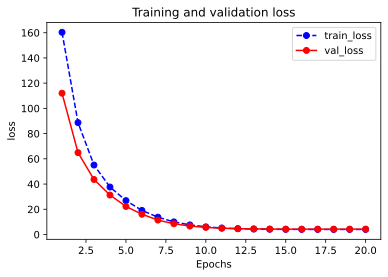

In [13]:
plot_metric(dfhistory,"loss")

![](./data/3-3-loss曲线.png)

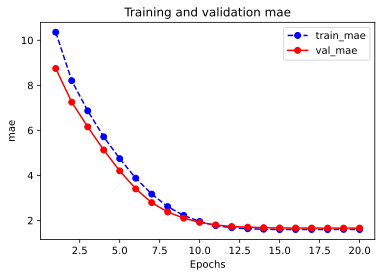

In [14]:
plot_metric(dfhistory,"mae")

![](./data/3-3-mape曲线.png)

In [15]:
# 评估
# {'val_loss': 4.2511159380276995, 'val_mae': 1.6610190868377686}
model.evaluate(dl_val)

100%|█████████████████████████████████| 12/12 [00:00<00:00, 600.75it/s, val_loss=4.25, val_mae=1.66]


{'val_loss': 4.2511159380276995, 'val_mae': 1.6610190868377686}

```
{'val_loss': 2.9377514322598777, 'val_mae': 1.3306695222854614}
```

**5，使用模型**

In [16]:
# 预测
dl = DataLoader(TensorDataset(X))
model.predict(dl, list_only_one_column=True)[0:10]

tensor([[ 2.4902],
        [30.7191],
        [-2.7517],
        [-6.2028],
        [28.7602],
        [ 3.9309],
        [18.8950],
        [17.6077],
        [ 9.9059],
        [27.8363]], device='cuda:0')

```
tensor([[ 3.9212],
        [ 8.6336],
        [ 6.1982],
        [ 6.1212],
        [-5.0974],
        [-6.3183],
        [ 4.6588],
        [ 5.5349],
        [11.9106],
        [24.6937]])
```

In [17]:
model.predict(dl_train)[0:10]

tensor([[ 4.3648],
        [-7.0497],
        [24.8901],
        [ 7.8132],
        [ 2.0985],
        [ 1.0765],
        [ 3.6049],
        [13.2762],
        [-6.3164],
        [-3.6461]], device='cuda:0')

### 二，DNN二分类模型

此范例我们通过继承torchkeras.LightModel模型接口，实现DNN二分类模型。


**1，准备数据**

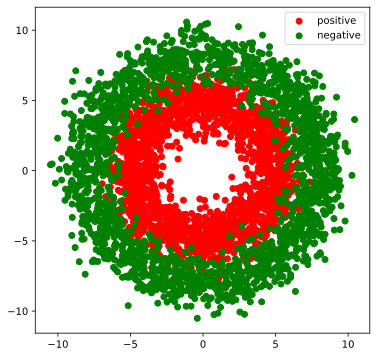

In [18]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset
import pytorch_lightning as pl 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


![](./data/3-3-分类数据可视化.png)

In [19]:
ds = TensorDataset(X,Y)

ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 100,shuffle=True,num_workers=0, collate_fn =cuda_collate_fn)
dl_val = DataLoader(ds_val,batch_size = 100,num_workers=0, collate_fn =cuda_collate_fn)

features,labels = next(iter(dl_train))

In [20]:
X.device

device(type='cpu')

**2，定义模型**

In [21]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y
    

In [22]:
net = Net()
net = net.to(device)
loss_fn = nn.BCEWithLogitsLoss()
metric_dict = {"acc":Accuracy()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

model = LightModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer,
                   lr_scheduler = lr_scheduler,
                  )       

# Layer (type)                            Output Shape              Param #
# ==========================================================================
# Linear-1                                     [-1, 4]                   12
# Linear-2                                     [-1, 8]                   40
# Linear-3                                     [-1, 1]                    9
# ==========================================================================
# Total params: 61
# Trainable params: 61
# Non-trainable params: 0
# --------------------------------------------------------------------------
# Input size (MB): 0.000069
# Forward/backward pass size (MB): 0.000099
# Params size (MB): 0.000233
# Estimated Total Size (MB): 0.000401
summary(model,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 4]                   12
Linear-2                                     [-1, 8]                   40
Linear-3                                     [-1, 1]                    9
Total params: 61
Trainable params: 61
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000401
--------------------------------------------------------------------------


D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(


**3，训练模型**

In [23]:
import pytorch_lightning as pl     

#1，设置回调函数
model_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    save_top_k=1,
    mode='max'
)

early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_acc',
                           patience=3,
                           mode = 'max'
                          )

#2，设置训练参数

# gpus=0 则使用cpu训练，gpus=1则使用1个gpu训练，gpus=2则使用2个gpu训练，gpus=-1则使用所有gpu训练，
# gpus=[0,1]则指定使用0号和1号gpu训练， gpus="0,1,2,3"则使用0,1,2,3号gpu训练
# tpus=1 则使用1个tpu训练
trainer = pl.Trainer(logger=True,
                     min_epochs=3,max_epochs=20,
#                      gpus=0,
                     accelerator="gpu",
                     callbacks = [model_ckpt,early_stopping],
                     enable_progress_bar = True) 


##4，启动训练循环
trainer.fit(model,dl_train,dl_val)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | Net               | 61    
1 | train_metrics | ModuleDict        | 2     
2 | val_metrics   | ModuleDict        | 2     
3 | test_metrics  | ModuleDict        | 2     
4 | loss_fn       | BCEWithLogitsLoss | 0     
----------------------------------------------------
61        Trainable params
6         Non-trainable params
67        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:29
{'val_count': 200, 'val_loss': 0.6593018770217896, 'val_acc': 0.5699999928474426, 'epoch': 0}


D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('val_count', ...)` in your `on_validation_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(
<<<<<< reach best val_acc : 0.5699999928474426 >>>>>>
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the nu

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:29
{'val_count': 1200, 'val_loss': 0.36325007180372876, 'val_acc': 0.8691666473944982, 'epoch': 0}
{'train_count': 2800, 'train_loss': 0.5208481060607093, 'train_acc': 0.7696428341524941, 'epoch': 0}


<<<<<< reach best val_acc : 0.8691666473944982 >>>>>>
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('train_count', ...)` in your `on_train_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:30
{'val_count': 1200, 'val_loss': 0.25050605709354085, 'val_acc': 0.9033333162466685, 'epoch': 1}
{'train_count': 2800, 'train_loss': 0.3045172340103558, 'train_acc': 0.8860714137554169, 'epoch': 1}


<<<<<< reach best val_acc : 0.9033333162466685 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:30
{'val_count': 1200, 'val_loss': 0.20838586737712225, 'val_acc': 0.9124999841054281, 'epoch': 2}
{'train_count': 2800, 'train_loss': 0.2479800661759717, 'train_acc': 0.8967856977667127, 'epoch': 2}


<<<<<< reach best val_acc : 0.9124999841054281 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:30
{'val_count': 1200, 'val_loss': 0.1782660906513532, 'val_acc': 0.9283333172400793, 'epoch': 3}
{'train_count': 2800, 'train_loss': 0.21678555251232215, 'train_acc': 0.9192856954676765, 'epoch': 3}


<<<<<< reach best val_acc : 0.9283333172400793 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:30
{'val_count': 1200, 'val_loss': 0.19815869132677713, 'val_acc': 0.9224999795357386, 'epoch': 4}
{'train_count': 2800, 'train_loss': 0.21283515595964023, 'train_acc': 0.9217857015984399, 'epoch': 4}


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:31
{'val_count': 1200, 'val_loss': 0.17766918117801347, 'val_acc': 0.9341666499773661, 'epoch': 5}
{'train_count': 2800, 'train_loss': 0.18875660108668463, 'train_acc': 0.9246428396020617, 'epoch': 5}


<<<<<< reach best val_acc : 0.9341666499773661 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:31
{'val_count': 1200, 'val_loss': 0.20007247105240822, 'val_acc': 0.9208333144585291, 'epoch': 6}
{'train_count': 2800, 'train_loss': 0.1843868927764041, 'train_acc': 0.9271428436040878, 'epoch': 6}


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:32
{'val_count': 1200, 'val_loss': 0.17171338386833668, 'val_acc': 0.9299999823172888, 'epoch': 7}
{'train_count': 2800, 'train_loss': 0.21402937732636929, 'train_acc': 0.9117856898478099, 'epoch': 7}


Validation: 0it [00:00, ?it/s]


================================================================================2023-05-29 17:18:32
{'val_count': 1200, 'val_loss': 0.181195929646492, 'val_acc': 0.9233333220084509, 'epoch': 8}
{'train_count': 2800, 'train_loss': 0.18989718625588076, 'train_acc': 0.9249999821186066, 'epoch': 8}


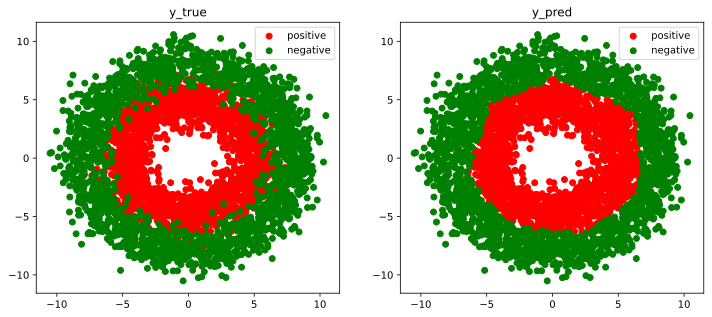

In [24]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(net.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(net.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


![](./data/3-3-分类结果可视化.png)

**4，评估模型**

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

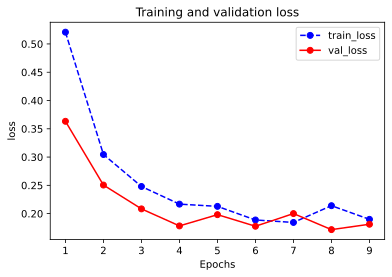

In [26]:
dfhistory  = model.get_history() 
plot_metric(dfhistory,"loss")


![](https://tva1.sinaimg.cn/large/e6c9d24egy1h491k7wtl0j20f70a6wes.jpg)

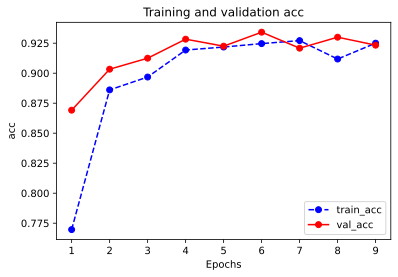

In [27]:
plot_metric(dfhistory,"acc")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h491k8if3hj20ev0aaglw.jpg)

In [28]:
#使用最佳保存点进行评估
# {'test_count': 1200, 'test_loss': 0.17766918117801347, 'test_acc': 0.9341666499773661}
trainer.test(ckpt_path='best', dataloaders=dl_val,verbose = False)

Restoring states from the checkpoint path at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_62\checkpoints\epoch=5-step=168.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_62\checkpoints\epoch=5-step=168.ckpt
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

{'test_count': 1200, 'test_loss': 0.17766918117801347, 'test_acc': 0.9341666499773661}


D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:212: UserWarning: You called `self.log('test_count', ...)` in your `on_test_epoch_end` but the value needs to be floating point. Converting it to torch.float32.
  warning_cache.warn(


[{'test_count': 1200.0,
  'test_loss': 0.17766918241977692,
  'test_acc': 0.934166669845581}]

```
{'test_loss': 0.18654096126556396, 'test_acc': 0.925000011920929}
```

**5，使用模型**

In [29]:
# tensor([[0.0206],
#         [0.0502],
#         [0.9745],
#         [0.0582],
#         [0.0694],
#         [0.0028],
#         [0.0215],
#         [0.0041],
#         [0.4365],
#         [0.9745]])
predictions = F.sigmoid(torch.cat(trainer.predict(model, dl_val, ckpt_path='best'))) 
predictions[:10]

Restoring states from the checkpoint path at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_62\checkpoints\epoch=5-step=168.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_62\checkpoints\epoch=5-step=168.ckpt
D:\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

tensor([[0.0206],
        [0.0502],
        [0.9745],
        [0.0582],
        [0.0694],
        [0.0028],
        [0.0215],
        [0.0041],
        [0.4365],
        [0.9745]])

```
tensor([[0.3873],
        [0.0028],
        [0.8772],
        ...,
        [0.9886],
        [0.4970],
        [0.8094]])
```

In [30]:
# tensor([[0.0206],
#         [0.0502],
#         [0.9745],
#         [0.0582],
#         [0.0694],
#         [0.0028],
#         [0.0215],
#         [0.0041],
#         [0.4365],
#         [0.9745]], device='cuda:0')
def predict(model,dl):
    model.eval()
    result = torch.cat([model.to(device).forward(t[0]) for t in dl])
    return(result.data)

predictions = F.sigmoid(predict(model,dl_val)[:10])
predictions

tensor([[0.0206],
        [0.0502],
        [0.9745],
        [0.0582],
        [0.0694],
        [0.0028],
        [0.0215],
        [0.0041],
        [0.4365],
        [0.9745]], device='cuda:0')

**6，保存模型**

In [31]:
# D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_58\checkpoints\epoch=5-step=168.ckpt
# tensor(0.9342, device='cuda:0')
print(trainer.checkpoint_callback.best_model_path)
print(trainer.checkpoint_callback.best_model_score)

D:\PycharmProjects\eat_pytorch_in_20_days\lightning_logs\version_62\checkpoints\epoch=5-step=168.ckpt
tensor(0.9342, device='cuda:0')


In [32]:
model_loaded = LightModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
D:\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:197: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(


In [33]:
# gpu: 2023-05-29 17:09:53:spent 8.958 秒
end_time = time.time()
print_with_time("spent {}".format(get_time_interval_str(end_time - start_time)))

2023-05-29 17:18:33:spent 9.346 秒


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)